In [53]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.plotting.register_matplotlib_converters()

import numpy as np
import seaborn as sns
import missingno as mgn

import plotly.express as px

Reading the data with standard preprocessing steps

In [54]:
# Just the new file only - for now
df1 = pd.read_excel('../data/data_d-drivers_2024-03-24.xlsx', sheet_name='data',
                    )
df2 = pd.read_excel('../data/data_d-drivers_2024-03-26.xlsx', sheet_name='data')

df1.columns = [col.lower() for col in df1.columns]
df2.columns = [col.lower() for col in df2.columns]

df1.rename({
           'impressions': 'page_impressions',
           'page_efahrer_id': 'page_id',
           'published_at': 'publishing_date',
           'page_canonical_url': 'url',
           'page_author': 'authors', 
            }, axis=1, inplace=True)

df2.rename({
           'impressions': 'page_impressions',
           'page_efahrer_id': 'page_id',
           'published_at': 'publishing_date',
           'page_canonical_url': 'url',
           'page_author': 'authors', 
            }, axis=1, inplace=True)

What makes each entry unique?

In [55]:
df1[df1[['page_id', 'date', 'url', 'authors', 'word_count']].duplicated(keep=False)] # keep=False keeps all duplicated values
                                    #.sort_values(['page_id', 'date', 'url', 'page_author'])

,page_id,date,publishing_date,publish_date_equal_to_date,url,page_name,classification_product,classification_type,title,authors,daily_likes,daily_dislikes,word_count,video_play,clickouts,external_clicks,external_impressions
66544,1018299,2024-03-04,NaT,N,https://efahrer.chip.de/news/neuvorstellung-des-fiat-pandina-der-panda-bekommt-ein-geschwisterchen_1018299,efa-1018299 | Der Panda bekommt ein kleines Geschwisterchen: Neuvorstellung des Fiat Pandina,Auto,News,Neuvorstellung des Fiat Pandina: Der Panda bekommt ein Geschwisterchen - EFAHRER.com,JÃ¼rgen Wolff,NaN,NaN,NaN,41.0,0.0,23.0,771.0
78658,1018299,2024-03-04,NaT,N,https://efahrer.chip.de/news/neuvorstellung-des-fiat-pandina-der-panda-bekommt-ein-geschwisterchen_1018299,efa-1018299 | Der Panda bekommt ein kleines Geschwisterchen: Neuvorstellung des Fiat Pandina,Auto,News,Neuvorstellung des Fiat Pandina: Der Panda bekommt ein Geschwisterchen - EFAHRER.com,JÃ¼rgen Wolff,NaN,NaN,NaN,NaN,NaN,NaN,NaN


By experimenting with different sets of columns I found those are 

> 'page_id', 'date', 'url', 'authors', 'word_count'

* NOT the `page_name`: it is totally broken
* NOT the `publishing_date`: sometimes the articles changed several times during the day and the word count changed, so `publishing_date` does not capture all combinations

Addressing the rows by all of those columns makes every article unique but just a single one: 1018299 (rows 66544 and 78658). But the second entry is just a mistake with all missing values, it can be simply dropped. 

In [56]:
df1.drop(78658, inplace=True)

Merge on those:

In [57]:
key_columns = ['page_id', 'date', 'url', 'authors', 'word_count']

What columns are in `df1` and not in `df2`?

In [58]:
print(df2.columns.difference(df1.columns))
print(df1.columns.difference(df2.columns))

Index(['page_impressions'], dtype='object')
Index(['clickouts'], dtype='object')


So the page impressions only present in the 2nd delivery, and clockouts only in the first delivery. 
We will merge the *first to the second*, so in the first dataset we only want to have the key columns and the unique one.

In [59]:
df1 = df1[key_columns + ['clickouts']]

What pages are in df1 and not in df2 and the other way around?

In [60]:
print(df1.set_index('page_id').index.difference(df2.set_index('page_id').index))
print(df2.set_index('page_id').index.difference(df1.set_index('page_id').index))

Index([], dtype='int64', name='page_id')
Index([1018667, 1018673, 1018687, 1018743, 1018770, 1018771, 1018776, 1018782], dtype='int64', name='page_id')


> The new data delivery includes all pages from the first one + 8 new ones.

What `URLs` are in df1 and not in df2 and the other way around?

In [61]:
print(df1.set_index('url').index.difference(df2.set_index('url').index))
print(df2.set_index('url').index.difference(df1.set_index('url').index))

Index([], dtype='object', name='url')
Index(['https://efahrer.chip.de/news/4-module-optionaler-speicher-haendler-setzt-balkonkraftwerk-auf-799-euro-runter_1017455',
       'https://efahrer.chip.de/news/ampeln-mit-neuer-farbe-weiss-will-das-leben-aller-verkehrsteilnehmer-verbessern_1011583',
       'https://efahrer.chip.de/news/angebot-nur-bis-ostern-so-bekommen-sie-1000-euro-rabatt-auf-ihre-solaranlage_1018573',
       'https://efahrer.chip.de/news/auch-mit-halterung-bei-diesem-balkonkraftwerk-preis-schlucken-selbst-discounter_1014858',
       'https://efahrer.chip.de/news/batterie-geheimnisse-maenner-sollen-tesla-bestohlen-und-firma-gegruendet-haben_1018770',
       'https://efahrer.chip.de/news/buegelschloss-mit-fingerabdrucksensor-bei-aldi_1013493',
       'https://efahrer.chip.de/news/dashcam-schnaeppchen-bei-amazon-das-taugt-die-kamera-fuer-unter-40-euro_1018667',
       'https://efahrer.chip.de/news/e-auto-fahrer-sind-fein-raus-deutsches-gericht-erzwingt-schaerfere-fahrverbote_10

> 22 new URLs

Which dates are new?

In [62]:
print(df1.set_index('date').index.difference(df2.set_index('date').index))
print(df2.set_index('date').index.difference(df1.set_index('date').index))

DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)
DatetimeIndex(['2024-03-23'], dtype='datetime64[ns]', name='date', freq=None)


> The day between the first and the second data deliveries, makes a lot of sense :D

In [63]:
if df1.shape == df1.drop_duplicates().shape:
    print('No duplicates left in the first dataframe')
else: 
    print('Duplicated entries present: merging will blow up the data frame size')

No duplicates left in the first dataframe


In [64]:
if df2[key_columns].shape == df2[key_columns].drop_duplicates().shape:
    print('No duplicates are in the second dataframe')
else: 
    print('Duplicated entries present: merging will blow up the data frame size')

Duplicated entries present: merging will blow up the data frame size


In [65]:
df2[df2[key_columns].duplicated(keep=False)] # keep=False keeps all duplicated values
                                    #.sort_values(['page_id', 'date', 'url', 'page_author'])

,page_id,date,publishing_date,publish_date_equal_to_date,url,page_name,classification_product,classification_type,title,authors,daily_likes,daily_dislikes,word_count,video_play,page_impressions,external_clicks,external_impressions
40600,1018299,2024-03-04,NaT,N,https://efahrer.chip.de/news/neuvorstellung-des-fiat-pandina-der-panda-bekommt-ein-geschwisterchen_1018299,efa-1018299 | Der Panda bekommt ein kleines Geschwisterchen: Neuvorstellung des Fiat Pandina,Auto,News,Der Panda bekommt ein kleines Geschwisterchen: Neuvorstellung des Fiat Pandina,Jürgen Wolff,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107004,1018299,2024-03-04,NaT,N,https://efahrer.chip.de/news/neuvorstellung-des-fiat-pandina-der-panda-bekommt-ein-geschwisterchen_1018299,efa-1018299 | Der Panda bekommt ein kleines Geschwisterchen: Neuvorstellung des Fiat Pandina,Auto,News,Der Panda bekommt ein kleines Geschwisterchen: Neuvorstellung des Fiat Pandina,Jürgen Wolff,NaN,NaN,NaN,41.0,72.0,23.0,771.0


Same mistake is in `df2`: remove it.

In [66]:
df2.drop(40600, inplace=True)

In [67]:
if df2[key_columns].shape == df2[key_columns].drop_duplicates().shape:
    print('No duplicates are in the second dataframe')
else: 
    print('Duplicated entries present: merging will blow up the data frame size')

No duplicates are in the second dataframe


Yuppi, now we are ready to merge!

## Merging

Using the `left` merging: we already know that `df1` is malformatted

In [ ]:
df = pd.merge(left=df2, right=df1, on=key_columns, how='left') 
# in principle, even the page_id is redundant in this case, 
# because each url contains the page id as the suffix

df

In [69]:
df2.shape

(132845, 17)

In [ ]:
mgn.matrix(df);

Cleaning up

In [72]:
del df1
del df2

## Imputing

In [141]:
df = df.sort_values(['page_id', 'date', 'publishing_date', 'url']).reset_index(drop=True)

In [ ]:
mgn.matrix(df);

#### Article versions

In [143]:
df[(df['publish_date_equal_to_date'] == 'Y') & (df['publishing_date'].isna())]

,page_id,date,publishing_date,publish_date_equal_to_date,url,page_name,classification_product,classification_type,title,authors,daily_likes,daily_dislikes,word_count,video_play,page_impressions,external_clicks,external_impressions,clickouts


Attention: some articles were scheduled for an update (or first publication), therefore have already existing entries and stats (likes, dislikes, etc.)

In [144]:
scheduled_articles = df.query('date < publishing_date')#[df.columns.drop(['url', 'title', 'page_name'])]

In [145]:
scheduled_articles_ids = scheduled_articles.page_id.unique()

In [176]:
df.columns

Index(['page_id', 'date', 'publishing_date', 'publish_date_equal_to_date',
       'url', 'page_name', 'classification_product', 'classification_type',
       'title', 'authors', 'daily_likes', 'daily_dislikes', 'word_count',
       'video_play', 'page_impressions', 'external_clicks',
       'external_impressions', 'clickouts'],
      dtype='object')

In [146]:
# Grouping, so we are not filling in the values from other articles!
versions = df.groupby(['page_id'], as_index=False, sort=True)[
    ['page_id', 'date', 'publishing_date', 'word_count']
    ].ffill()
#versions.rename({'index': 'page_id'}, axis=1, inplace=True)
versions

,page_id,date,publishing_date,word_count
0,1037,2024-03-13,2024-03-10,827.0
1,1037,2024-03-13,2024-03-10,827.0
2,1037,2024-03-14,2024-03-10,827.0
3,1037,2024-03-15,2024-03-10,827.0
4,1037,2024-03-16,2024-03-10,827.0
...,...,...,...,...
132840,1018768,2024-03-23,NaT,NaN
132841,1018770,2024-03-23,NaT,NaN
132842,1018771,2024-03-23,NaT,NaN
132843,1018776,2024-03-23,NaT,NaN


In [147]:
versions.query('date < publishing_date').shape[0] == scheduled_articles.shape[0]

False

In [148]:
wtf_idx = versions.query('date < publishing_date').index.difference(scheduled_articles.index)
wtf_idx

Index([14802, 54942, 54943, 54944, 54945, 67690, 67691, 91857], dtype='int64')

<font color=red> We'll assume that all articles which don't have a publishing date but were scheduled for an update are actually REALLY OLD and were published at the around inception of EFAHRER (01-01-2018) </font>

In [161]:
df.loc[df.date < df.publishing_date, 'publishing_date'] = pd.Timestamp('2018-01-01 00:00:00')

For some pages we simply don't know the date of first publication! We need to impute it for modelling.
Which articles are those?

In [92]:
no_publ_date = versions[versions.publishing_date.isna()].page_id.unique()
no_publ_date

array([  10245,   10273,   10372, ..., 1018771, 1018776, 1018782])

In [93]:
no_publ_date.shape 

(2319,)

In [95]:
len(no_publ_date) / len(df.page_id.unique())

0.33613567183649806

So those entries comprise almost 34 % of all articles :(

**For those we apply the same imputing**

In [162]:
df.loc[df.page_id.isin(no_publ_date), 'publishing_date'] = pd.Timestamp('2018-01-01 00:00:00')

<font color=red> Assuming that when the word counts do not change unless ptherwise specified </font>

In [173]:
versions2 = df.groupby(['page_id'], as_index=False, sort=True)[
    ['page_id', 'date', 'publishing_date', 'word_count']
    ].ffill().drop_duplicates()

versions2

,page_id,date,publishing_date,word_count
0,1037,2024-03-13,2024-03-10,827.0
2,1037,2024-03-14,2024-03-10,827.0
3,1037,2024-03-15,2024-03-10,827.0
4,1037,2024-03-16,2024-03-10,827.0
5,1037,2024-03-17,2024-03-10,827.0
...,...,...,...,...
132840,1018768,2024-03-23,2018-01-01,NaN
132841,1018770,2024-03-23,2018-01-01,NaN
132842,1018771,2024-03-23,2018-01-01,NaN
132843,1018776,2024-03-23,2018-01-01,NaN


In [124]:
versions[(versions.date < versions.publishing_date)]

,page_id,date,publishing_date,word_count,publish_date_equal_to_date
89633,105345,2023-01-12,2023-01-13,1939.0,N
1370,107173,2023-07-13,2023-07-14,937.0,N
14,107341,2023-01-13,2023-01-16,602.0,N
33732,107341,2023-01-13,2023-01-16,602.0,N
101787,107341,2023-01-15,2023-01-16,602.0,N
44870,1011437,2023-04-21,2023-04-22,918.0,N
90710,1011437,2023-07-13,2023-07-14,882.0,N
119475,1011759,2023-05-19,2023-05-22,698.0,N
68467,1011759,2023-05-19,2023-05-22,698.0,N
85111,1011759,2023-05-19,2023-05-22,698.0,N


Merging the imputed columns back in:

In [166]:
versions2.columns

Index(['page_id', 'date', 'publishing_date', 'word_count'], dtype='object')

In [102]:
df.columns.drop('publishing_date').drop('word_count')

Index(['page_id', 'date', 'publish_date_equal_to_date', 'url', 'page_name',
       'classification_product', 'classification_type', 'title', 'authors',
       'daily_likes', 'daily_dislikes', 'video_play', 'page_impressions',
       'external_clicks', 'external_impressions', 'clickouts'],
      dtype='object')

In [171]:
df_imputed = pd.merge(df[df.columns.drop('publishing_date').drop('word_count')], # drop the non-imputed columns
                      versions2,
                      on=['page_id', 'date'], how='left')

In [ ]:
mgn.matrix(df_imputed)

#### Daily reactions

In [ ]:
df['daily_likes']

### Merging in the scraped data

Thanks Clara

In [177]:
df_scraped = pd.read_csv('../data/scraping_no_duplicates.csv')
df_scraped.columns = [col.lower() for col in df_scraped.columns]

df_scraped.rename({
           #'impressions': 'page_impressions',
           'words': 'words_scraped',
           'page_efahrer_id': 'page_id',
           'page_canonical_url': 'url',
           'author': 'author_scraped',
           'current_title': 'h1'
            }, axis=1, inplace=True)

col_to_merge = ['page_id', 'url']
df_full = pd.merge(left=df, right=df_scraped, on=col_to_merge, how='left')

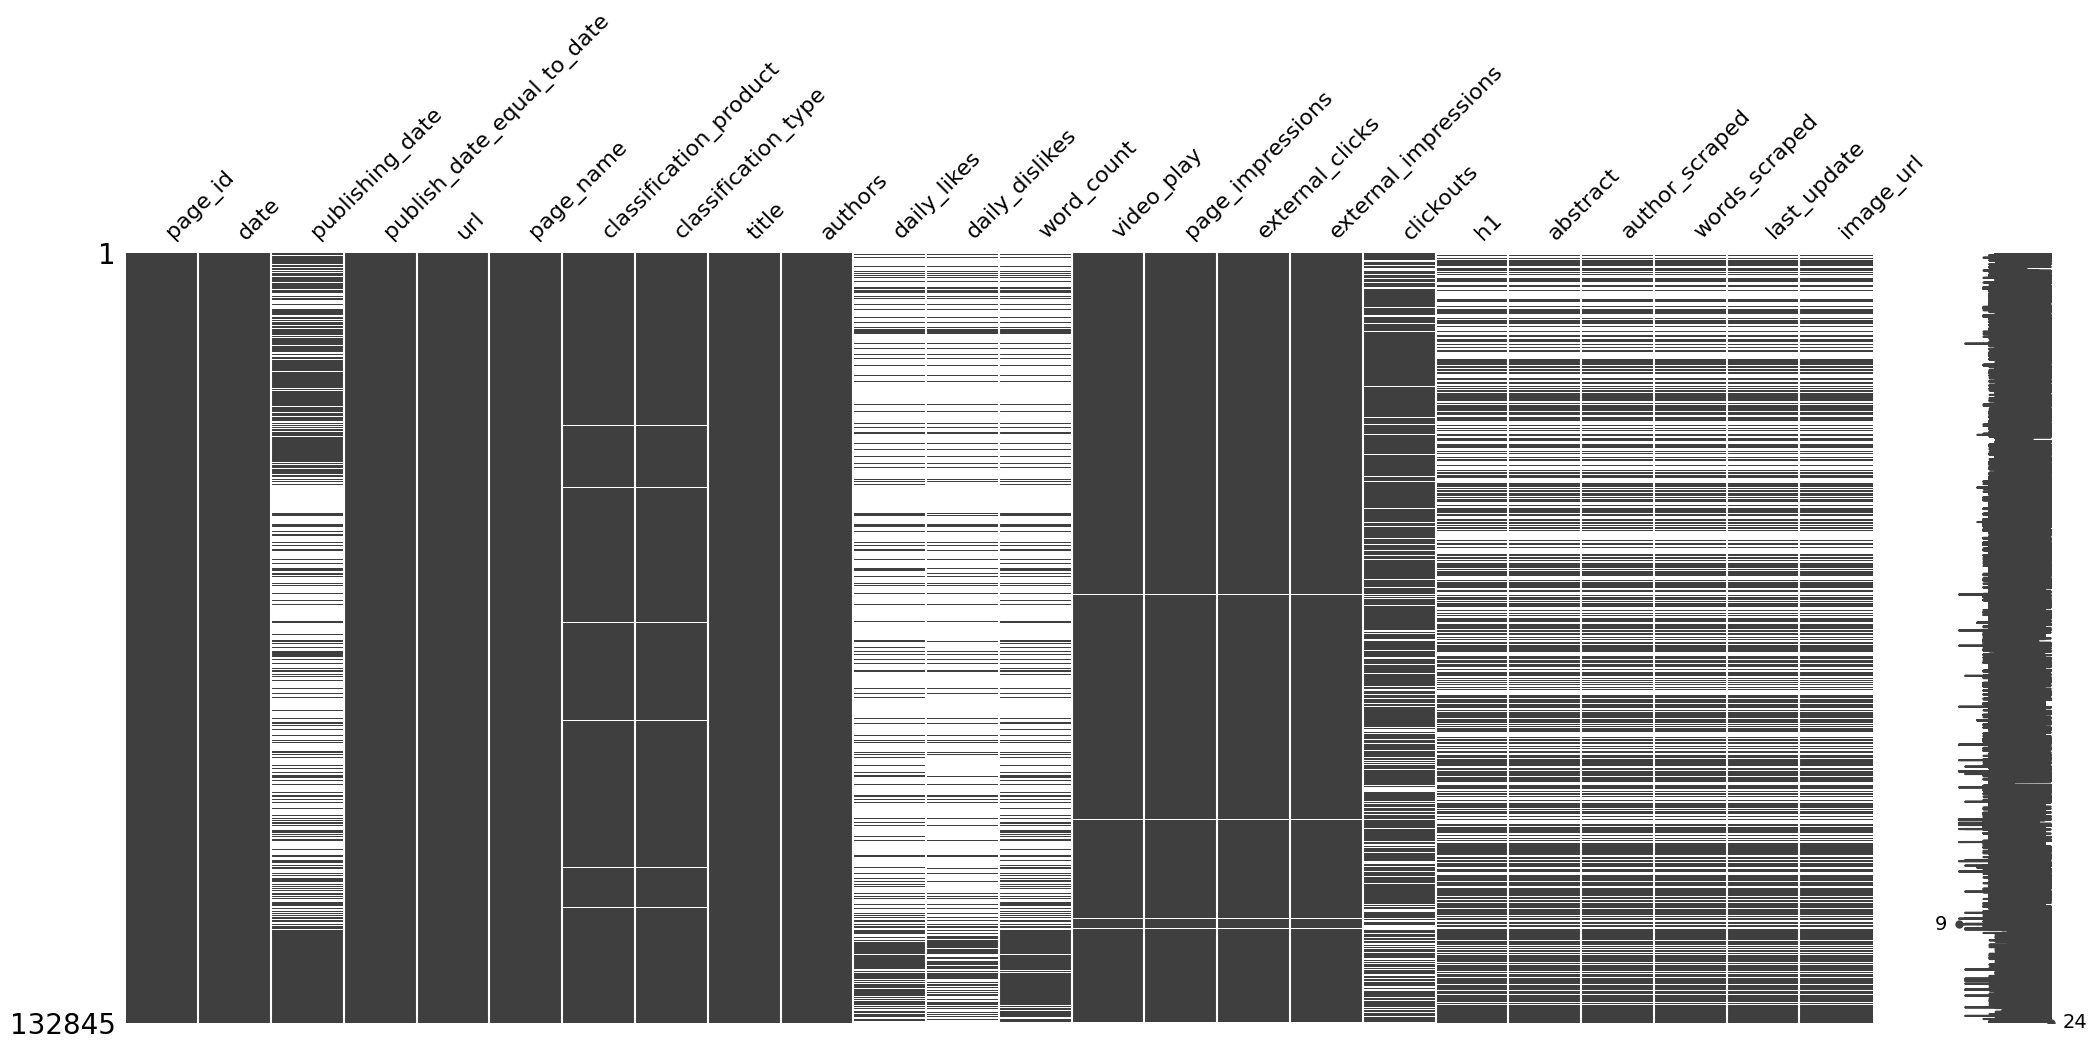

In [179]:
mgn.matrix(df_full);

---

# Aggregating 

For using in subprojects

In [ ]:
page_unique_features = ['page_id', 'publishing_date', 'word_count', 'authors']

In [183]:
(df[page_unique_features+['date']].drop_duplicates().value_counts() > 1).sum()

0

this means they are really unique

#### Versions

In [ ]:
df.groupby(page_unique_features).

### User-side

User side features: those which the reader sees

In [ ]:
user_side_features = ['page_id', 'date', 'publish_date', 'word_count', 'words_scraped', 
                    'page_title', 'page_name', 'title', 'h1', 'authors',  
                    'classification_product', 'classification_type']

---

## Feature engineering

### Article (content) versions

We want to label each version.
* Version changes when there is a new `publication date`
* Version changes when there is a new `word count`
* Version does NOT change with a change in `URL`
* Version does NOT change with a change in the `date` column

In [ ]:
# Only the necessary columns
# we still need the 'date' column for imputation
df_cnt = df[['page_efahrer_id', 'date', 'published_at', 'word_count']]
df_cnt = df_cnt.sort_values(['page_efahrer_id', 'date', 'published_at'])
df_cnt

In [ ]:
mgn.matrix(df_cnt);

There are some columns where the publication date changed but the `word count` was not updated!

In [ ]:
wcna_idx = df_cnt[df_cnt.word_count.isna() & df_cnt.published_at.notna()].index
wcna_idx

NOT the other way around:

In [ ]:
df_cnt[df_cnt.word_count.notna() & df_cnt.published_at.isna()].index

The best assumption that it did not change (significantly??), so still forward-fill it.

In [ ]:
df_cnt = df_cnt.ffill()

In [ ]:
sus = df_cnt.loc[wcna_idx]

#### Versions

In [ ]:
df_cnt['publ_at_enc'] = df_cnt.groupby('page_efahrer_id')['published_at'].transform(lambda x: pd.factorize(x)[0])
df_cnt

How many versions does each article have?

In [ ]:
to_plot = df_cnt[['page_efahrer_id', 'publ_at_enc']].groupby('page_efahrer_id').max()#.reset_index()
first_publ_date = df_cnt[['page_efahrer_id', 'published_at']].groupby('page_efahrer_id').min()
first_publ_date = first_publ_date.rename({'published_at': 'First publication date'}, axis=1)
to_plot = to_plot.join(first_publ_date)
to_plot = to_plot.rename({'publ_at_enc': 'Number of versions'}, axis=1)
to_plot

In [ ]:
px.scatter(data_frame=to_plot, x='Number of versions', y='First publication date')

Article with 61 (!!!) versions:

In [ ]:
metrics_cols = ['page_canonical_url', 'daily_likes', 
               'daily_dislikes', 'impressions', 'video_play', 
               'discover_clicks', 'discover_impressions']

In [ ]:
article105259 = df[df['page_efahrer_id']==105259].sort_values(['date', 'page_canonical_url'])
article_first_url = article105259[metrics_cols + ['date']].drop_duplicates(subset=['date'], keep='first')

In [ ]:
import matplotlib.pyplot as plt

xticks=pd.date_range(df.date.min(), df.date.max(), freq='2M')
fig = article_first_url.plot(kind='bar', x='date', y=metrics_cols, subplots=True, figsize=(6, 12), 
                       xticks=xticks)
plt.gca().set_xticklabels([x.strftime('%a\n%d\n%h\n%Y') for x in xticks]);
#plt.xticks(ticks=df[['impressions', 'published_at']].resample('W', on='published_at').max().index);
#plt.xticks(ticks=pd.date_range(df.date.min(), df.date.max(), freq='2M'),
#           labels=pd.date_range(df.date.min(), df.date.max(), freq='2M'));